In [1]:
%%time
import importlib
import pandas as pd
import numpy as np
import scipy as scp
import glob

import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import seaborn as sns

import sprawl
from sprawl import plotting, utils

CPU times: user 1.57 s, sys: 331 ms, total: 1.91 s
Wall time: 2.35 s


# Make three-panel plots for significant gene/metrics

In [2]:
%%time
#read in all gene/cell info for both mice over all metrics (this is a large table)
all_BICCN_gene_cells = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/*.csv')
gene_cell_df = pd.concat((
    pd.read_csv(p, usecols=['metric','annotation','gene','score','num_gene_spots'])
    for p in all_BICCN_gene_cells
))
gene_cell_df

CPU times: user 19.7 s, sys: 3.02 s, total: 22.7 s
Wall time: 23.7 s


,metric,annotation,gene,num_gene_spots,score
0,puncta,Endo,Cxcl14,3,-0.488000
1,puncta,Endo,Flt1,66,0.458000
2,puncta,Endo,Aqp4,2,-0.250000
3,puncta,Endo,Acta2,3,-0.848000
4,puncta,Endo,Timp3,17,0.566000
...,...,...,...,...,...
4669863,central,L5_IT,Tmem163,1,-0.303371
4669864,central,L5_IT,Tox,9,-0.198502
4669865,central,L5_IT,Trpc4,3,-0.820225
4669866,central,L5_IT,Wipf3,14,-0.033708


In [3]:
%%time
#creating subsetted gtf to prepare for ReadZs score extraction

#this bam is from BICCN_10Xv3 has cell-type and sample of origin information as XO and RG tags respectively
bam_path = '../../inputs/BICCN_10Xv3_scRNAseq.bam'

#this is the conservation track from the genome browser
bw_path = '/oak/stanford/groups/horence/rob/isoform_localizations/sprawl/inputs/mm10.60way.phyloP60wayPlacental.bw'
    
#mouse gtf file to be able to plot exons/introns/UTRs
full_gtf = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/sprawl/inputs/gencode.vM23.annotation.gtf',
    comment = '#',
    sep = '\t',
    header = None,
    names = ['chrom','source','kind','start','end','dot1','strand','dot2','info'],
)
gtf = full_gtf[full_gtf['kind'].isin(['exon','UTR'])]
gtf['label'] = gtf['info'].str.extract('gene_name "(.*?)";')
gtf['group'] = gtf['info'].str.extract('transcript_id "(.*?)";')

#Fam19a2 gene synonym Tafa2 is used in the gtf. changing it to match the gene/cell table
#Fam84b gene synonym Lratd2 is used in the gtf. changing it to match the gene/cell table
gtf.loc[gtf['label'].eq('Tafa2'),'label'] = 'Fam19a2'
gtf.loc[gtf['label'].eq('Lratd2'),'label'] = 'Fam84b'

#Get the MERFISH gene names from the gene_ont outputs
gene_ont_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_ont/*')
BICCN_genes_df = pd.concat((pd.read_csv(p, usecols=['gene']) for p in gene_ont_paths), ignore_index=True)
BICCN_genes = set(BICCN_genes_df['gene'])

#sanity checking gene labels match between GTF and spatial
#Determine how many genes are present in both the gtf and the gene/cell table
gtf_genes = set(gtf['label'])
shared_genes = BICCN_genes.intersection(gtf_genes)
BICCN_only_genes = BICCN_genes.difference(gtf_genes)

print('There are',len(gtf_genes),'unique genes in the gtf')
print('There are',len(BICCN_genes),'unique genes in the gene/cell table')
print('There are',len(shared_genes),'genes shared between both')
print('Genes present only in the gene/cell table',BICCN_only_genes)

#subset the gtf to just the entries with the shared genes
gtf = gtf[gtf['label'].isin(shared_genes)]

#have to 'manually' distinguish between 5' and 3' UTRs
for (transcript_id,strand),t in gtf.groupby(['group','strand']):
    if strand == '+':
        utr3_start = t[t['kind'].eq('exon')]['end'].max()
        utr_3s = t[t['kind'].eq('UTR') & t['end'].ge(utr3_start)]
    elif strand == '-':
        utr3_start = t[t['kind'].eq('exon')]['start'].min()
        utr_3s = t[t['kind'].eq('UTR') & t['start'].le(utr3_start)]
    else:
        sys.stderr.write('strand error\n')
        break
        
    gtf.loc[utr_3s.index,'kind'] = '3UTR'


#Determine which loci to plot by:
#1) selecting genes that are in both the gtf and the gene/cell table
#2) selecting on UTRs
#3) grouping by gene and expanding left to the 5'-most UTR start, and right to the 3'-most UTR end
#   this is important for genes with multiple annotated 3' UTRs
#4) add a bit of "padding" on either side of the locus as 1% of the span
loci = gtf[
    gtf['label'].isin(shared_genes) &
    gtf['kind'].eq('3UTR')
][['label','chrom','start','end','strand']].drop_duplicates()

loci = loci.groupby(['label','chrom','strand']).agg(
    start = ('start','min'),
    end = ('end','max'),
).reset_index()

padding = loci['end'].subtract(loci['start']).multiply(0.01).astype(int)
loci['start'] -= padding
loci['end'] += padding

print('There are',len(loci),'loci to use for plotting')

There are 55228 unique genes in the gtf
There are 252 unique genes in the gene/cell table
There are 242 genes shared between both
Genes present only in the gene/cell table {'Blank-7', 'Blank-3', 'Blank-6', 'Blank-2', 'Blank-5', 'Blank-8', 'Blank-1', 'Blank-9', 'Blank-10', 'Blank-4'}
There are 241 loci to use for plotting
CPU times: user 12.1 s, sys: 585 ms, total: 12.7 s
Wall time: 15.6 s


In [4]:
gene = [
    'Timp3',  'Chn2',  'Chn2',  'Chn2',  'Chn2',  'Asic4',  'Asic4',  'Rgs6',  
    'Rgs6',  'Rgs6',  'Rgs6',  'Slc32a1',  'Slc32a1',  'Nr2f2',  'Nr2f2',  
    'Nr2f2',  'Tbc1d4',  'Tbc1d4',  'Dscaml1',  'Dscaml1',  'Meis2',  'Meis2',  
    'Meis2',  'Meis2',  'Cxcl14',  'Cxcl14',  'Cxcl14',  'Nxph1',  'Nxph1',  
    'Pcdh8',  'Nkain3',  'Nr4a1',  'Satb2',  'Satb2',  'Satb2',  'Satb2',  
    'Cdh13',  'Cdh13',  'Camk2d',  'Rnf152',  'Prss23',  'Igfbp4',  'Igfbp4',  
    'Igfbp4',  'Igfbp4',  'Shisa9',  'Shisa9',  'Shisa9',  'Shisa9',  'Slc30a3',  
    'Slc30a3',  'Slc30a3',  'Igfbp5',  'Wipf3',  'Wipf3',  'Wipf3',  'Wipf3',  
    'Trp53i11',  'Trp53i11',  'Trp53i11',  'Marcksl1',
]
len(set(gene))

26

In [5]:
#these were determined to be significant from the "merfish_BICCN" notebook in this same folder
sig_gene_metrics = pd.DataFrame({
    'gene': [
        'Timp3',  'Chn2',  'Chn2',  'Chn2',  'Chn2',  'Asic4',  'Asic4',  'Rgs6',  
        'Rgs6',  'Rgs6',  'Rgs6',  'Slc32a1',  'Slc32a1',  'Nr2f2',  'Nr2f2',  
        'Nr2f2',  'Tbc1d4',  'Tbc1d4',  'Dscaml1',  'Dscaml1',  'Meis2',  'Meis2',  
        'Meis2',  'Meis2',  'Cxcl14',  'Cxcl14',  'Cxcl14',  'Nxph1',  'Nxph1',  
        'Pcdh8',  'Nkain3',  'Nr4a1',  'Satb2',  'Satb2',  'Satb2',  'Satb2',  
        'Cdh13',  'Cdh13',  'Camk2d',  'Rnf152',  'Prss23',  'Igfbp4',  'Igfbp4',  
        'Igfbp4',  'Igfbp4',  'Shisa9',  'Shisa9',  'Shisa9',  'Shisa9',  'Slc30a3',  
        'Slc30a3',  'Slc30a3',  'Igfbp5',  'Wipf3',  'Wipf3',  'Wipf3',  'Wipf3',  
        'Trp53i11',  'Trp53i11',  'Trp53i11',  'Marcksl1',
    ],
    'metric': [
        'periph',  'central',  'periph',  'puncta',  'radial',  'central',  'periph',  
        'central',  'periph',  'puncta',  'radial',  'puncta',  'radial',  'periph',  
        'puncta',  'radial',  'puncta',  'radial',  'periph',  'central',  'central',  
        'periph',  'puncta',  'radial',  'radial',  'periph',  'central',  'central',  
        'periph',  'radial',  'central',  'radial',  'central',  'periph',  'puncta',  
        'radial',  'puncta',  'radial',  'central',  'puncta',  'puncta',  'radial',  
        'puncta',  'central',  'periph',  'radial',  'puncta',  'periph',  'central',  
        'central',  'periph',  'radial',  'radial',  'central',  'periph',  'puncta',  
        'radial',  'central',  'periph',  'radial',  'radial',
    ]
})

sig_gene_metrics

,gene,metric
0,Timp3,periph
1,Chn2,central
2,Chn2,periph
3,Chn2,puncta
4,Chn2,radial
...,...,...
56,Wipf3,radial
57,Trp53i11,central
58,Trp53i11,periph
59,Trp53i11,radial


In [6]:
%%time
pdf = plotting.make_pdf('three_panel_significant_genes.pdf')

for i,r in sig_gene_metrics.iterrows():
    gene = r['gene']
    metric = r['metric']
    
    gene,chrom,strand,start,end = loci[loci['label'].eq(gene)].values[0]
    region = (chrom,strand,start,end)
    
    gene_metric_df = gene_cell_df[
        gene_cell_df['gene'].eq(gene)
        & gene_cell_df['metric'].eq(metric)
    ]
    
    fig = three_panel_slrrp_readzs(gene_metric_df, bam_path, region, cons_path=bw_path)
    plt.suptitle(
        f'{gene} {metric}', 
        x=0, y=1.15,
        horizontalalignment='left',
        verticalalignment='top',
        fontsize = 25,
    )
    pdf.savefig(fig, bbox_inches='tight')
    plt.show(fig)
    plt.close()

pdf.close()

NameError: name 'three_panel_slrrp_readzs' is not defined

# Plotting function

Maybe move this to sprawl.plotting, no immediate rush though this function is just for this analysis

In [7]:
import pyBigWig

def three_panel_slrrp_readzs(gene_cell_df, bam_path, region, cons_path=None):
    #Get the reads from the bam file
    chrom,strand,start,end = region
    read_locations = utils.bam_read_positions(bam_path, (chrom,start,end), stratify_tag='XO')

    #Add the min and max pos as a datapoint to each cell-type for plotting
    strats = read_locations['strat'].unique().tolist()
    edge_positions = pd.DataFrame({
        'strat':strats*2,
        'pos':[start]*len(strats)+[end]*len(strats),
    })
    
    read_locations = pd.concat((read_locations, edge_positions))
    
    #Convert from genomic coordinates to UTR length
    if strand == '+':
        read_locations['pos'] = read_locations['pos']-start
    else:
        read_locations['pos'] = end-read_locations['pos']
    
    #assumes this is a table of just one gene/metric
    gene = gene_cell_df['gene'].mode().values[0]
    metric = gene_cell_df['metric'].mode().values[0]
    
    #Filter SLRRP datasets
    min_gene_spots_per_cell = 1
    min_cells_per_ann = 100

    filt_gene_cell_df = (
        gene_cell_df[
            gene_cell_df['num_gene_spots'].ge(min_gene_spots_per_cell)
        ].groupby(
            'annotation'
        ).filter(
            lambda g: len(g) >= min_cells_per_ann
        )
    )

    #Filter Read buildups
    min_reads_per_ann = 100

    filt_read_locations = (
        read_locations.groupby('strat').filter(lambda g: len(g) > min_reads_per_ann)
    )

    #Find shared genes and sort them by increasing median score
    annots = set(filt_gene_cell_df['annotation']).intersection(filt_read_locations['strat'])

    filt_gene_cell_df = filt_gene_cell_df[filt_gene_cell_df['annotation'].isin(annots)]
    filt_read_locations = filt_read_locations[filt_read_locations['strat'].isin(annots)]
    
    #Set the middling annots (not the 2 highest nor the 2 lowest) to be 'Other' to simplify plotting
    annots_by_med_score = filt_gene_cell_df.groupby('annotation')['score'].median().sort_values()
    middling_annots = annots_by_med_score.index[2:-2]
    
    space_df = filt_gene_cell_df.copy()
    space_df.loc[space_df['annotation'].isin(middling_annots),'annotation'] = '[Other]'
    
    utr_df = filt_read_locations.copy()
    utr_df.loc[utr_df['strat'].isin(middling_annots),'strat'] = '[Other]'

    #Order the annotations by spatial score
    annot_order = (
        space_df.groupby('annotation')['score'].median()
        .sort_values()
        .index.values.tolist()
    )
    
    #Make the combined plot
    fig,((space_ax,utr_ax,corr_ax),(ll_ax,cons_ax,lr_ax)) = plt.subplots(
        figsize = (15,6),
        nrows = 2, ncols = 3,
        sharex = False, sharey = False,
        gridspec_kw={'height_ratios': [5, 1]}, #heights per row
    )
    ll_ax.axis('off')
    lr_ax.axis('off')
    cons_ax.axis('off')   

    ###################
    #Make the space_ax#
    ###################
    sns.boxplot(
        x = 'score',
        y = 'annotation',
        boxprops = {'facecolor':'None', 'edgecolor':'black'},
        whiskerprops = {'color':'black'},
        medianprops = {'color':'red'},
        fliersize = 0,
        order = annot_order,
        data = space_df,
        ax = space_ax,
    )
    sns.stripplot(
        x = 'score',
        y = 'annotation',
        color = 'grey',
        order = annot_order,
        zorder = -1,
        data = space_df.groupby('annotation').sample(100, replace=True), #subsample the stripplots
        ax = space_ax,
    )

    #Get median scores to add as x-axis ticks
    median_scores = list(space_df.groupby('annotation')['score'].median().values)

    #Lots of personalization to remove splines and format ticks etc
    space_ax.spines.right.set_visible(False)
    space_ax.spines.left.set_visible(False)
    space_ax.spines.bottom.set_visible(False)
    space_ax.set_ylabel('')
    space_ax.yaxis.tick_right()
    space_ax.set_yticklabels([])
    space_ax.xaxis.tick_top()
    space_ax.set_xlabel(f'{metric.capitalize()} score',fontsize=20)
    space_ax.xaxis.set_label_position('top')
    space_ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([-1,0,1]))
    space_ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(median_scores))
    space_ax.tick_params(
        axis='x',which='major',length=3,width=3,color='k',direction='out', labelsize=10,
    )
    space_ax.tick_params(
        axis='x',which='minor',length=6,width=1,color='r',direction='inout',
    )
    space_ax.tick_params(
        axis='y',labelsize=12,
    )

    ###################
    # Make the utr_ax #
    ###################
    
    #make dummy hue variable
    dummy_filt_read_locations = utr_df.copy()
    dummy_filt_read_locations['_half'] = 'half' 
    dummy_df = pd.DataFrame({'strat': '_', 'pos': -1, '_half': '_'},index=[len(dummy_filt_read_locations)])
    dummy_filt_read_locations = pd.concat((dummy_filt_read_locations,dummy_df))

    sns.violinplot(
        x = 'pos',
        y = 'strat',
        hue = '_half',
        bw = 0.05, #controls smoothness (bw=bandwith), smaller is less smoothed
        split = True,
        cut = 0,
        inner = 'quartile',
        palette = ['grey','black'], #second color is never used since there is a "fake" hue
        order = annot_order,
        data = dummy_filt_read_locations,
        ax = utr_ax,
    )
    
    #color the medians red (every third line starting with the 2nd line)
    #this feels so hacky but there are no handles to do this from within sns.violinplot
    for i,l in enumerate(utr_ax.lines):
        if i%3 == 1:
            l.set_color('red')
            l.set_linestyle('solid')
        else:
            l.set_color('grey')

    median_readzs_locations = list(utr_df.groupby('strat')['pos'].median().values)
    utr_ax.legend([],[], frameon=False)
    utr_ax.spines.right.set_visible(False)
    utr_ax.spines.left.set_visible(False)
    utr_ax.spines.bottom.set_visible(False)
    utr_ax.set_ylabel('')
    utr_ax.set_xlabel("3' UTR length proxy",fontsize=20)
    utr_ax.set_xlim(0,end-start)
    utr_ax.xaxis.tick_top()
    utr_ax.xaxis.set_label_position('top')
    utr_ax.xaxis.set_minor_locator(matplotlib.ticker.FixedLocator(median_readzs_locations))
    utr_ax.tick_params(
        axis='x',which='major',length=3,width=3,color='k',direction='out', labelsize=10,
    )
    utr_ax.tick_params(
        axis='x',which='minor',length=6,width=1,color='r',direction='inout'
    )
    utr_ax.tick_params(
        axis='y',labelsize=12,
    )
    
    #Add a 3' UTR diagram above the plot
    # Loop over data points; create box from errors at each point
    last_exon_box = Rectangle(
        (-0.15, 1.2), width=0.15, height=0.1,
        color = 'grey',
        clip_on=False, transform=utr_ax.transAxes,
    )
    UTR_box = Rectangle(
        (0.0, 1.225), width=1.0, height=0.05,
        color = 'grey',
        clip_on=False, transform=utr_ax.transAxes,
    )

    # Add collection to axes
    utr_ax.add_patch(last_exon_box)
    utr_ax.add_patch(UTR_box)
    

    ####################
    # Make the corr_ax #
    ####################
    corr_df = pd.concat(
        (
            filt_gene_cell_df.groupby('annotation')['score'].median(),
            filt_read_locations.groupby('strat')['pos'].median()
        ),
        axis = 1,
    )
    corr_order = filt_gene_cell_df.groupby('annotation')['score'].median().sort_values().index
    corr_df = corr_df.loc[corr_order]
    corr_df = corr_df.reset_index()


    sns.scatterplot(
        x = 'pos',
        y = 'score',
        s = 100,
        hue = 'annotation',
        palette = 'Oranges_r',
        data = corr_df.head(2),
        ax = corr_ax,
    )
    sns.regplot(
        x = 'pos',
        y = 'score',
        ci = None,
        line_kws = {'linestyle':'dashed','color':'grey'},
        scatter_kws = {'zorder':-1},
        label = '[Other]',
        color = 'grey',
        data = corr_df,
        ax = corr_ax,
    )
    sns.scatterplot(
        x = 'pos',
        y = 'score',
        s = 100,
        hue = 'annotation',
        palette = 'Blues',
        data = corr_df.tail(2),
        ax = corr_ax,
    )

    
    p_r,p_p = scp.stats.pearsonr(corr_df['score'], corr_df['pos'])
    s_r,s_p = scp.stats.spearmanr(corr_df['score'], corr_df['pos'])

    corr_ax.set_title(
        """
        Median spatial and 3' UTR correlation
        Pearson r={:.2} p={:.2f}
        Spearman r={:.2} p={:.2f}
        """.format(p_r,p_p,s_r,s_p),
        fontsize=15
    )
    corr_ax.set_xlabel("Median 3' UTR length proxy",fontsize=15)
    corr_ax.set_ylabel(f'Median {metric} score',fontsize=15)
    corr_ax.legend(
        title='Cell types',
        loc=2,
        bbox_to_anchor=(1.05, 1),
        ncol=1,
        borderaxespad=0.,
        fontsize=12,
    )
    corr_ax.spines.right.set_visible(False)
    corr_ax.spines.top.set_visible(False)
    
    ####################
    # Make the cons_ax #
    ####################
    #Plot the conservation data if present
    #Known issue that the utr_ax and the cons_ax are not sharing the x-axis
    #tried addressing this but ran into lots of issues, not worth it to make the slight adjustment
    if cons_path:
        bw = pyBigWig.open(cons_path)
        
        #the zip is needed to "transpose" from [(start,value),(start,value)] to [(start,start),(value,value)]
        cons_df = pd.DataFrame(zip(*((s,v) for (s,e,v) in bw.intervals(chrom, start, end)))).T
        cons_df.columns = ['pos','cons']
        
        if strand == '+':
            cons_df['pos'] = cons_df['pos']-start
        else:
            cons_df['pos'] = end-cons_df['pos']
        
        #smooth the data for plotting
        num_bins = 500
        cut_bins = pd.cut(cons_df['pos'],bins=num_bins).map(lambda b: b.left).astype(int)
        plot_df = cons_df.groupby(cut_bins)['cons'].mean().reset_index()
        plot_df['Negative'] = plot_df['cons'].lt(0)

        sns.barplot(
            x = 'pos',
            y = 'cons',
            hue = 'Negative',
            dodge = False,
            palette = ['blue','red'],
            data = plot_df,
            ax = cons_ax,
        )
        cons_ax.legend([],[],frameon=False)
        #cons_ax.set_xlim(0,end-start) #doesn't work since each bar is labelled 1,2,3 instead of actual value

    return fig


# Make cell-plots for Figure 4

In [1]:
import glob
import pandas as pd
import numpy as np
import sprawl
from sprawl import plotting

In [ ]:
cell_paths = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/*')
df = pd.concat(pd.read_csv(p) for p in cell_paths)
df

In [ ]:
np.random.seed(1)

template_hdf5_path = '../../inputs/hdf5s/BICCN_mouse{}sample{}.hdf5'

gene_metric_cell_types = [
    ('Asic4','central','Lamp5'),
    ('Asic4','central','Vip'),
    ('Asic4','central','L6_CT'),
    ('Asic4','central','L5_IT'),
    
    ('Slc32a1','puncta','Pvalb'),
    ('Slc32a1','puncta','Lamp5'),
    ('Slc32a1','puncta','L6_CT'),
    ('Slc32a1','puncta','L6_IT'),
    
    ('Nr2f2','radial','Vip'),
    ('Nr2f2','radial','L6_IT_Car3'),
    ('Nr2f2','radial','L6_IT'),
    ('Nr2f2','radial','L6_CT'),
]

for gene,metric,ct in gene_metric_cell_types:
    cells = df[
        df['gene'].eq(gene)
        & df['metric'].eq(metric)
        & df['annotation'].eq(ct)
        & df['num_gene_spots'].ge(3)
    ]
    
    low_score_cell = cells[cells['score'].le(-0.7)].sample(1).iloc[0]
    high_score_cell = cells[cells['score'].ge(0.7)].sample(1).iloc[0]
    
    low_m,low_s = low_score_cell['sample'][1],low_score_cell['sample'][3]
    low_sample = sprawl.HDF5(template_hdf5_path.format(low_m,low_s))
    low_cell = low_sample.get_cells_by_id([low_score_cell['cell_id']])[0]

    high_m,high_s = high_score_cell['sample'][1],high_score_cell['sample'][3]
    high_sample = sprawl.HDF5(template_hdf5_path.format(high_m,high_s))
    high_cell = high_sample.get_cells_by_id([high_score_cell['cell_id']])[0]
    
    out_name = f'fig4_cell_plots/{gene}_{metric}_{ct}_low.png'
    fig,ax = plotting.plot_cell_3D(low_cell, gene_colors={gene:'red'})
    ax.view_init(elev=90, azim=0)
    plt.title(out_name)
    plt.savefig(out_name)
    plt.show()
    plt.close()
    
    out_name = f'fig4_cell_plots/{gene}_{metric}_{ct}_high.png'
    fig,ax = plotting.plot_cell_3D(high_cell, gene_colors={gene:'red'})
    ax.view_init(elev=90, azim=0)
    plt.title(out_name)
    plt.savefig(out_name)
    plt.show()
    plt.close()
    


In [42]:
cells

,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample
2472864,central,311922302772936149634773950802544228290,L6_CT,513,Asic4,6,-0.781250,0.106511,BICCN_mouse1,m1s3
3121662,central,276730711099753783509703946940881404596,L6_CT,576,Asic4,10,-0.107826,0.074831,BICCN_mouse1,m1s4
4040121,central,21602327318872906014335330120110363222,L6_CT,672,Asic4,10,0.120715,0.074964,BICCN_mouse1,m1s4
4735123,central,189179301007259224115843348720310394413,L6_CT,286,Asic4,5,-0.221053,0.141841,BICCN_mouse1,m1s5
6035664,central,158068956804458780169144119512575554718,L6_CT,314,Asic4,5,0.246006,0.141933,BICCN_mouse1,m1s6


# Appendix

Sandbox to make the three-panel plots

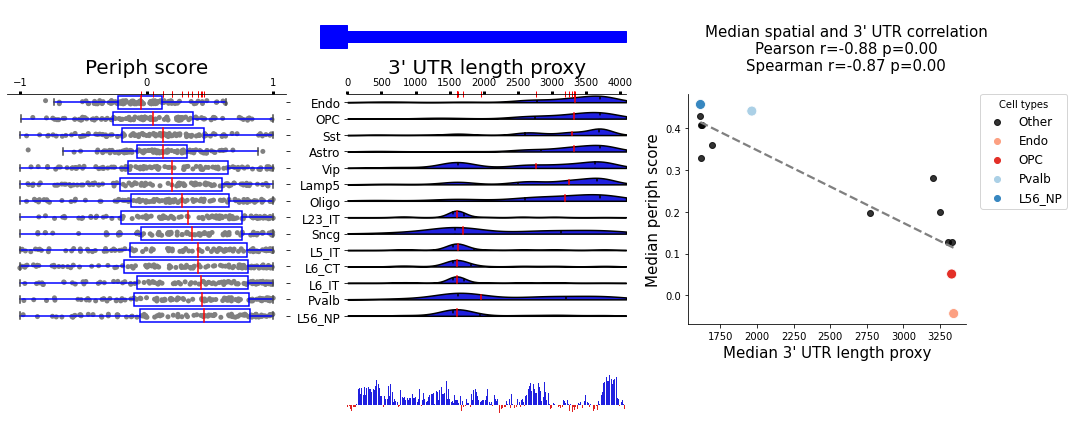

CPU times: user 11.6 s, sys: 132 ms, total: 11.8 s
Wall time: 36.9 s


In [207]:
%%time
#Plotting Timp3 test data
fig = three_panel_slrrp_readzs(timp3_gene_cell_df, bam_path, timp3_region, cons_path=bw_path)
fig.tight_layout()
plt.savefig('Timp3_three_panel.svg')
plt.show(fig)
plt.close()

In [134]:
%%time
#Getting ReadZs Timp3 data
bam_path = '../../inputs/BICCN_10Xv3_scRNAseq.bam'
timp3_region = ('chr10','+',86345548,86349641)
bw_path = '/oak/stanford/groups/horence/rob/isoform_localizations/sprawl/inputs/mm10.60way.phyloP60wayPlacental.bw'

#Getting SLRRP Timp3/peripheral data
all_BICCN_gene_cells = glob.glob('../../nf_pipeline/outputs/BICCN_20220601_direct/gene_cell/*.csv')
cell_df = pd.concat((pd.read_csv(p) for p in all_BICCN_gene_cells))
timp3_gene_cell_df = cell_df[cell_df['gene'].eq('Timp3') & cell_df['metric'].eq('periph')]
timp3_gene_cell_df

CPU times: user 37.3 s, sys: 7.85 s, total: 45.2 s
Wall time: 45.7 s


,metric,cell_id,annotation,num_spots,gene,num_gene_spots,score,variance,experiment,sample
109,periph,222098490380092065288492113826920653088,L23_IT,521,Timp3,2,-0.028846,0.166986,BICCN_mouse1,m1s1
385,periph,324936583968035907461485415440119465532,Vip,229,Timp3,7,-0.298246,0.109136,BICCN_mouse1,m1s1
463,periph,212380056445062369967464310553750468306,L6_CT,522,Timp3,2,0.928983,0.166985,BICCN_mouse1,m1s1
744,periph,214530813541466051618442266501415668881,L5_IT,555,Timp3,3,0.740072,0.199997,BICCN_mouse1,m1s1
869,periph,208216926404047031835800982290964847257,Endo,230,Timp3,17,-0.048035,0.049382,BICCN_mouse1,m1s1
...,...,...,...,...,...,...,...,...,...,...
4669313,periph,208743345960016814592334592699605472748,Vip,301,Timp3,1,0.980000,0.335556,BICCN_mouse2,m2s6
4669393,periph,238521953712186391613754269351915970304,L6_CT,359,Timp3,1,-0.396648,0.335196,BICCN_mouse2,m2s6
4669492,periph,88420504046119131887363245653515131289,L23_IT,757,Timp3,1,-0.806878,0.334215,BICCN_mouse2,m2s6
4669579,periph,90158513615378526382798271915354218091,L6_CT,468,Timp3,1,-0.593148,0.334761,BICCN_mouse2,m2s6


In [8]:
#Installing pyBigWig to read from the bigWig consensus file
#import sys
#!{sys.executable} -m pip install pyBigWig

#downloaded the bigWig file from:
#https://hgdownload.soe.ucsc.edu/goldenPath/mm10/phyloP60way/mm10.60way.phyloP60wayPlacental.bw
import pyBigWig
bw_path = '/oak/stanford/groups/horence/rob/isoform_localizations/sprawl/inputs/mm10.60way.phyloP60wayPlacental.bw'
bw = pyBigWig.open(bw_path)
bw